# CLEAN BUILD FROM SCRATCH MIT-B2 on patches 768x768

In [1]:
CURRENT_FOLD = 3

# imports

In [2]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

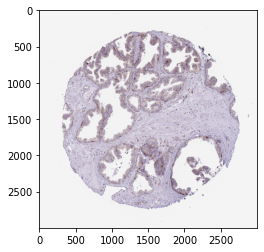

In [3]:
img1 = cv.imread('./../data/train_images/10044.tiff')[:, :, ::-1]
plt.imshow(img1)
plt.show()

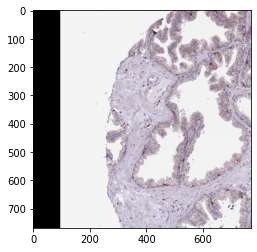

In [4]:
img2 = cv.imread('./../data/train_images_patches_768_overlap/10044_00010.png')[:, :, ::-1]
plt.imshow(img2)
plt.show()

In [5]:
# for fname in tqdm(glob('./../data/train_images_patches_768_overlap/*.png')):
#     img = cv.imread(fname)
#     cv.imwrite(fname, img[:, :, ::-1])

# data

In [6]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [7]:
from model_coat_daformer import *
from coat import *

## data 768

In [8]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_patches_1024_overlap/'
TRAIN_MASKS_DIR = './../data/train_masks_patches_1024_overlap/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 768 # размер патча


In [9]:
train_df = pd.read_csv(TRAIN_CSV)

In [10]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [11]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [12]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [13]:
def make_768_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('train_images_', 'train_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [14]:
train_df_768 = make_768_dataset(train_df)
print(train_df_768.shape)
train_df_768.head()

(5616, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_images_patches_1024_overlap/10...,./../data/train_masks_patches_1024_overlap/100...,prostate,0.4
1,4.0,10044,./../data/train_images_patches_1024_overlap/10...,./../data/train_masks_patches_1024_overlap/100...,prostate,0.4
2,4.0,10044,./../data/train_images_patches_1024_overlap/10...,./../data/train_masks_patches_1024_overlap/100...,prostate,0.4
3,4.0,10044,./../data/train_images_patches_1024_overlap/10...,./../data/train_masks_patches_1024_overlap/100...,prostate,0.4
4,4.0,10044,./../data/train_images_patches_1024_overlap/10...,./../data/train_masks_patches_1024_overlap/100...,prostate,0.4


In [15]:
train_df_768.iloc[0]['image']

'./../data/train_images_patches_1024_overlap/10044_00013.png'

In [16]:
train_df_768.iloc[0]['mask']

'./../data/train_masks_patches_1024_overlap/10044_00013.png'

In [17]:
train_df_768.iloc[0]['id']

10044

In [18]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [19]:
# mean = np.array([0.7720342, 0.74582646, 0.76392896])
# std = np.array([0.24745085, 0.26182273, 0.25782376])

In [20]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.5),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [21]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [22]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])

        data.update(upd_data)
        return data

In [23]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [24]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 1024, 1024])
image values:  0.15294118225574493 0.9647059440612793


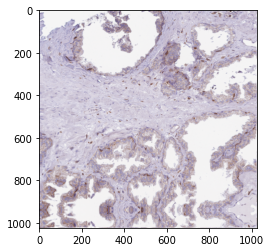

MASK
torch.Size([1024, 1024])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


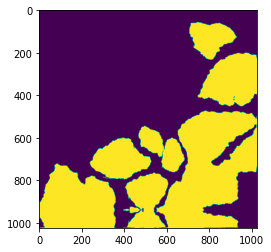

In [25]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [26]:
BATCH_SIZE = 5

In [27]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 1024, 1024])
image values:  0.027450982481241226 1.0


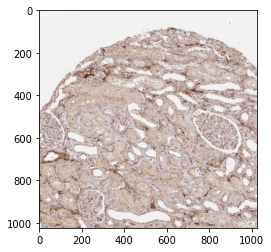

MASK
torch.Size([1024, 1024])
mask values:  tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


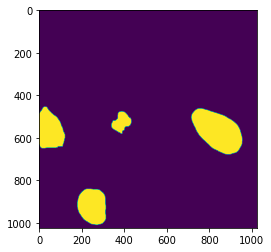

In [28]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# model

In [29]:
!nvidia-smi

Tue Sep  6 17:51:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   49C    P0    42W / 300W |     57MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   50C    P0    56W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [30]:
device = 'cuda:0'
DEVICE = device

In [31]:
encoder = coat_parallel_small_depth5
decoder = daformer_conv3x3

model = Net(encoder=encoder, decoder=decoder, n_classes=6)

# setting up SWA process (due to shared weights)

In [32]:
swa_model = AveragedModel(model)

In [57]:
for el in ['./checkpoint_fold_3/coat-small_ep_030_dice_0.775207.pt',
           './checkpoint_fold_3/coat-small_ep_030_dice_0.775207.pt',
           './checkpoint_fold_3/coat-small_ep_030_dice_0.775207.pt']:
    model.load_state_dict(torch.load(el, map_location=device))
    swa_model.update_parameters(model, )

In [59]:
for key in model.state_dict().keys():
    print(key)

rgb.mean
rgb.std
encoder.cls_token1
encoder.cls_token2
encoder.cls_token3
encoder.cls_token4
encoder.patch_embed1.proj.weight
encoder.patch_embed1.proj.bias
encoder.patch_embed1.norm.weight
encoder.patch_embed1.norm.bias
encoder.patch_embed2.proj.weight
encoder.patch_embed2.proj.bias
encoder.patch_embed2.norm.weight
encoder.patch_embed2.norm.bias
encoder.patch_embed3.proj.weight
encoder.patch_embed3.proj.bias
encoder.patch_embed3.norm.weight
encoder.patch_embed3.norm.bias
encoder.patch_embed4.proj.weight
encoder.patch_embed4.proj.bias
encoder.patch_embed4.norm.weight
encoder.patch_embed4.norm.bias
encoder.cpe1.proj.weight
encoder.cpe1.proj.bias
encoder.cpe2.proj.weight
encoder.cpe2.proj.bias
encoder.cpe3.proj.weight
encoder.cpe3.proj.bias
encoder.cpe4.proj.weight
encoder.cpe4.proj.bias
encoder.crpe1.conv_list.0.weight
encoder.crpe1.conv_list.0.bias
encoder.crpe1.conv_list.1.weight
encoder.crpe1.conv_list.1.bias
encoder.crpe1.conv_list.2.weight
encoder.crpe1.conv_list.2.bias
encoder.crp

In [58]:
for key in model.state_dict().keys():
    W1 = model.state_dict()[key]
    W2 = swa_model.module.state_dict()[key]
    if not (torch.isclose(W1, W2).all().item()):
        print(key)
#     break

decoder.mlp.0.1.running_mean
decoder.mlp.0.1.running_var
decoder.mlp.0.1.num_batches_tracked
decoder.mlp.1.1.running_mean
decoder.mlp.1.1.running_var
decoder.mlp.1.1.num_batches_tracked
decoder.mlp.2.1.running_mean
decoder.mlp.2.1.running_var
decoder.mlp.2.1.num_batches_tracked
decoder.mlp.3.1.running_mean
decoder.mlp.3.1.running_var
decoder.mlp.3.1.num_batches_tracked
decoder.fuse.1.running_mean
decoder.fuse.1.running_var
decoder.fuse.1.num_batches_tracked
aux_heads_serial.0.1.running_mean
aux_heads_serial.0.1.running_var
aux_heads_serial.0.1.num_batches_tracked
aux_heads_serial.1.1.running_mean
aux_heads_serial.1.1.running_var
aux_heads_serial.1.1.num_batches_tracked
aux_heads_serial.2.1.running_mean
aux_heads_serial.2.1.running_var
aux_heads_serial.2.1.num_batches_tracked
aux_heads_serial.3.1.running_mean
aux_heads_serial.3.1.running_var
aux_heads_serial.3.1.num_batches_tracked


# calculating SWA try1

In [33]:
chkpts = []
for fname in sorted(glob('./checkpoint_fold_3/coat-small_ep_*_dice_*.pt')):
#     print(fname)
    bname = os.path.basename(fname)
    spt = bname.split('_')
    epoch = int(spt[4])
    dice = float(spt[6].rsplit('.', maxsplit=1)[0])
    print(epoch, dice)
    chkpts.append((fname, dice, epoch))

1200 0.777401
1800 0.772339
600 0.762626
22800 0.765828
23400 0.77643
24000 0.763194
24600 0.763395
25200 0.778118
25800 0.748614
26400 0.774094
27000 0.768515
27600 0.77218
28200 0.764369
28800 0.768161
29400 0.771364
30000 0.767804
30600 0.77161
31200 0.770505
31800 0.774743
32400 0.776003
33000 0.775107
33600 0.771625
34200 0.774965
34800 0.773554
35400 0.778801
36000 0.76845
36600 0.771729
37200 0.764235
37800 0.76812
38400 0.769135
39000 0.763615
39600 0.77055
40200 0.771617
40800 0.770141
41400 0.762986
42000 0.766384
42600 0.764236
43200 0.772674
43800 0.772586
44400 0.752483
2400 0.77784
3000 0.771256
3600 0.767715
4200 0.776047
45000 0.767473
45600 0.774444
46200 0.772438
46800 0.773815
47400 0.767533
48000 0.760333
48600 0.770801
49200 0.774949
49800 0.76488
50400 0.766239
51000 0.769393
51600 0.759403
52200 0.760345
52800 0.749298
53400 0.75991
54000 0.759986
54600 0.762936
4800 0.772423
5400 0.782896
6000 0.77667
6600 0.775149
7200 0.784075
7800 0.76805
8400 0.77841
10200 0

In [34]:
chkpts = list(sorted(chkpts, key=lambda x: x[1]))

In [35]:
chkpts[-5:]

[('./checkpoint_fold_3/coat-small_ep_15_it_35400_dice_0.778801.pt',
  0.778801,
  35400),
 ('./checkpoint_fold_3/coat-small_ep_4_it_10200_dice_0.779216.pt',
  0.779216,
  10200),
 ('./checkpoint_fold_3/coat-small_ep_4_it_9000_dice_0.782399.pt',
  0.782399,
  9000),
 ('./checkpoint_fold_3/coat-small_ep_2_it_5400_dice_0.782896.pt',
  0.782896,
  5400),
 ('./checkpoint_fold_3/coat-small_ep_3_it_7200_dice_0.784075.pt',
  0.784075,
  7200)]

In [43]:
chkpts[-5:]

[('./checkpoint_fold_3/coat-small_ep_1_it_4200_dice_0.776047.pt',
  0.776047,
  4200),
 ('./checkpoint_fold_3/coat-small_ep_2_it_6000_dice_0.776670.pt',
  0.77667,
  6000),
 ('./checkpoint_fold_3/coat-small_ep_0_it_1200_dice_0.777401.pt',
  0.777401,
  1200),
 ('./checkpoint_fold_3/coat-small_ep_1_it_2400_dice_0.777840.pt',
  0.77784,
  2400),
 ('./checkpoint_fold_3/coat-small_ep_2_it_5400_dice_0.782896.pt',
  0.782896,
  5400)]

In [36]:
model.load_state_dict(torch.load(chkpts[-1][0], map_location=device))

<All keys matched successfully>

In [37]:
swa_model = AveragedModel(model)

In [38]:
for el in chkpts[-5:]:
    model.load_state_dict(torch.load(el[0], map_location=device))
    swa_model.update_parameters(model)

In [39]:
model.load_state_dict(torch.load(chkpts[-1][0], map_location=device))

<All keys matched successfully>

In [40]:
swa_state_dict = swa_model.state_dict()

In [41]:
for key in model.state_dict().keys():
    if 'num_batches_tracked' in key or \
        '.cpe.' in key or \
        '.crpe.' in key:
        print('replaced:', key)
        swa_state_dict['module.' + key] = model.state_dict()[key]

replaced: encoder.serial_blocks1.0.cpe.proj.weight
replaced: encoder.serial_blocks1.0.cpe.proj.bias
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.0.weight
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.0.bias
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.1.weight
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.1.bias
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.2.weight
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.2.bias
replaced: encoder.serial_blocks1.1.cpe.proj.weight
replaced: encoder.serial_blocks1.1.cpe.proj.bias
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.0.weight
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.0.bias
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.1.weight
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.1.bias
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.2.wei

replaced: encoder.parallel_blocks.2.factoratt_crpe3.crpe.conv_list.2.weight
replaced: encoder.parallel_blocks.2.factoratt_crpe3.crpe.conv_list.2.bias
replaced: encoder.parallel_blocks.2.factoratt_crpe4.crpe.conv_list.0.weight
replaced: encoder.parallel_blocks.2.factoratt_crpe4.crpe.conv_list.0.bias
replaced: encoder.parallel_blocks.2.factoratt_crpe4.crpe.conv_list.1.weight
replaced: encoder.parallel_blocks.2.factoratt_crpe4.crpe.conv_list.1.bias
replaced: encoder.parallel_blocks.2.factoratt_crpe4.crpe.conv_list.2.weight
replaced: encoder.parallel_blocks.2.factoratt_crpe4.crpe.conv_list.2.bias
replaced: encoder.parallel_blocks.2.factoratt_crpe5.crpe.conv_list.0.weight
replaced: encoder.parallel_blocks.2.factoratt_crpe5.crpe.conv_list.0.bias
replaced: encoder.parallel_blocks.2.factoratt_crpe5.crpe.conv_list.1.weight
replaced: encoder.parallel_blocks.2.factoratt_crpe5.crpe.conv_list.1.bias
replaced: encoder.parallel_blocks.2.factoratt_crpe5.crpe.conv_list.2.weight
replaced: encoder.parall

In [42]:
swa_model.load_state_dict(swa_state_dict)

<All keys matched successfully>

In [74]:
# model.load_state_dict(torch.load('./checkpoint_fold_3_SAM/mit-b2_ep_501_dice_0.772775.pt', map_location=device))

# don't forget to call this after training

In [75]:
# swa_model.load_state_dict(torch.load('..'))

In [43]:
device

'cuda:0'

In [44]:
swa_model = swa_model.to(device)

In [45]:
class HubmapDataset1024(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index % 100 == 0:
            print(index)
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        
        image = self.transform(image=image)['image'].to(device)

        return {'image': image, 'organ': organ}

In [46]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [47]:
train_dataset = HubmapDataset1024(train_df_768[train_df_768['fold'] != CURRENT_FOLD], val_transform)
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=3, 
                          shuffle=False,
                          worker_init_fn=worker_init_fn,
                          num_workers=0
                         )

In [ ]:
torch.optim.swa_utils.update_bn(loader_train, swa_model)

0


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [49]:
torch.save(swa_model.state_dict(), os.path.join(
                    './checkpoint_fold_{}'.format(CURRENT_FOLD), 
                    'coat-small-depth5-fold3_TOP_5_BEST_MORE_EPOCHS.pt'
                )) 

In [ ]:
# no amp version

In [ ]:
for epoch in range(0, N_EPOCHS):
    criterion_image, criterion_aux = criterion_schedule(epoch)
    
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
        
        batch['image'] = batch['image'].to(device)
        batch['mask' ] = batch['mask' ].to(device, dtype=torch.long)
#         batch['organ'] = batch['organ'].cuda()
        
        unfreeze_running_stats(model)

        output = model(batch)
        loss0      = criterion_image(output['out_logits'],   batch['mask'])
        loss_aux1  = criterion_aux  (output['aux1_logits'],  batch['mask']).mean()
        loss_aux2  = criterion_aux  (output['aux2_logits'],  batch['mask']).mean()
        loss = loss0 + 0.05 * loss_aux1 + 0.2 * loss_aux2
        
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        freeze_running_stats(model)  # <- this is the important line

        output = model(batch)
        loss0      = criterion_image(output['out_logits'],   batch['mask'])
        loss_aux1  = criterion_aux  (output['aux1_logits'],  batch['mask']).mean()
        loss_aux2  = criterion_aux  (output['aux2_logits'],  batch['mask']).mean()
        loss_act = loss0 + 0.05 * loss_aux1 + 0.2 * loss_aux2
            
        loss_act.backward()
        
        optimizer.second_step(zero_grad=True)
                 
        batch_train_loss.append(loss_act.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 5) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))


        if iteration % (VIRTUAL_BATCH_SIZE * 40) == 0:
            clear_output()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    if epoch > SWA_START:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        
    # val -------------------------------
    if epoch % 3 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                PTH_CKPT, 
                'mit-b2_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 
            if epoch > SWA_START:
                torch.save(swa_model.state_dict(), os.path.join(
                    PTH_CKPT, 
                    'mit-b2_swa_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
                )) 
            logfile.flush()
    